
## World Fertility Data
### World Fertility Data 2019
 
World Fertility Data 2019 presents age-specific fertility rates, total fertility, and mean age at childbearing for 201 countries or areas of the world. It includes empirical data from civil registration systems, population censuses, and sample surveys available as of August 2019 and covers the time period from 1950 to the present.

The dataset builds on the historical repository of demographic data and census and survey reports collected over the past 50 years by the Population Division and Statistics Division of the United Nations Department of Economic and Social Affairs. Estimates based on data compiled from civil registration systems are generally obtained from National Statistical Offices. Additional sources of data include the Demographic and Health Surveys (DHS), the Multiple Indicator Cluster Surveys (MICS), the Reproductive Health Surveys (RHS), the Statistical Office of the European Union (Eurostat), the Human Fertility Database (HFD), the Human Fertility Collection (HFC), the Pan-Arab Project for Child Development Surveys (PAPCHILD), the Pan-Arab Project for Family Health Survey (PAPFAM), national surveys, as well as fertility estimates produced by the Population Division of DESA.
 
Note. The empirical data used for deriving estimates in World Population Prospects 2019 are not necessarily the same as reported in World Fertility Data 2019 due to the time lag between the two publications. Moreover, fertility estimates in World Population Prospects 2019 may incorporate additional adjustments to account for cohort sizes in consecutive censuses.

## Visualizing Fertility Data


This notebook creates interesting visualizations of the fertility data, hopefully adding some insight into the future of humanity.


#### Install packages for this notebook
Remove the `--quiet` to see the installation process.


In [1]:
import warnings
warnings.filterwarnings('ignore')
! python -m pip install --upgrade pip --quiet
! pip install --upgrade setuptools --quiet
! pip install altair geopandas pandas openpyxl tabulate ipyleaflet matplotlib mapclassify shapely branca ipywidgets jupyter google mpld3 --quiet

#### Imports

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json
import gc
import datetime
import shapely
import mapclassify
from shapely import wkt
from ipyleaflet import Map, GeoData, LayersControl, basemaps, basemap_to_tiles, GeoJSON, WidgetControl, Popup
from IPython.display import display
import ipywidgets as widgets
import branca.colormap as cm
from ipywidgets import HTML, VBox
from branca.colormap import linear
from shapely.geometry import shape


## Recap of Data, Goals, and Tasks

The primary objective of this project is to visualize global fertility trends using the World Fertility Data 2019. The dataset includes age-specific fertility rates, total fertility rates, and mean age at childbearing for over 200 countries. The aim is to present this data through engaging, interactive visualizations that allow users to explore how fertility patterns have evolved across different regions and age groups.

### Key Tasks:
- Create interactive maps to visualize fertility rates globally.
- Provide insights into global demographic trends and project potential future changes.

### Key Definitions:
#### Fertility Metrics: TFR, MAC, and ASFR

This section explains key fertility metrics, including Total Fertility Rate (TFR), Mean Age at Childbearing (MAC), and Age-Specific Fertility Rate (ASFR), along with their corresponding calculations.

#### 1. Age-Specific Fertility Rate (ASFR)
The **Age-Specific Fertility Rate (ASFR)** represents the number of live births per 1,000 women in a specific age group during a defined period, typically one year.

#### Formula:
$$
ASFR = \left( \frac{\text{Number of live births to women in a specific age group}}{\text{Number of women in that age group}} \right) \times 1000
$$

#### Example:
If there are 50 live births to women aged 20-24 in a year, and the population of women in that age group is 10,000, the ASFR would be:

$$
ASFR = \left( \frac{50}{10,000} \right) \times 1000 = 5 \, \text{live births per 1,000 women in that age group}
$$

#### 2. Total Fertility Rate (TFR)
The **Total Fertility Rate (TFR)** estimates the average number of children a woman would have if she experienced the current Age-Specific Fertility Rates (ASFRs) throughout her reproductive years (usually ages 15-49).

#### Formula:
$$
TFR = \sum_{i=1}^{n} \left( ASFR_i \times \frac{5}{1000} \right)
$$
Where:
- \( ASFR_i \) is the Age-Specific Fertility Rate for the \( i \)-th age group.
- \( n \) is the number of age groups.

#### Example:
If the ASFR for the age groups 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, and 45-49 are provided, the TFR is calculated as the sum of the ASFRs for each group, adjusted for the 5-year intervals.

#### 3. Mean Age at Childbearing (MAC)
The **Mean Age at Childbearing (MAC)** represents the average age at which women give birth. It is calculated by weighting the ages of women in each age group by their ASFRs and dividing by the total number of live births.

#### Formula:
$$
MAC = \frac{\sum_{i=1}^{n} (a_i \times ASFR_i)}{\sum_{i=1}^{n} ASFR_i}
$$
Where:
- \( a_i \) is the mid-point of each age group (e.g., 17.5 for 15-19, 22.5 for 20-24, etc.).
- \( ASFR_i \) is the Age-Specific Fertility Rate for the \( i \)-th age group.

#### Example:
If the ASFR for different age groups is known, the MAC can be calculated by summing the product of each age group's mid-point and its ASFR, and dividing by the total ASFR.




## Screenshots of the Visualization

### Images of the visualization 
These are screen shot of the visualization from the datasets available. 
 - TFR
 - MAC
 - ASFR

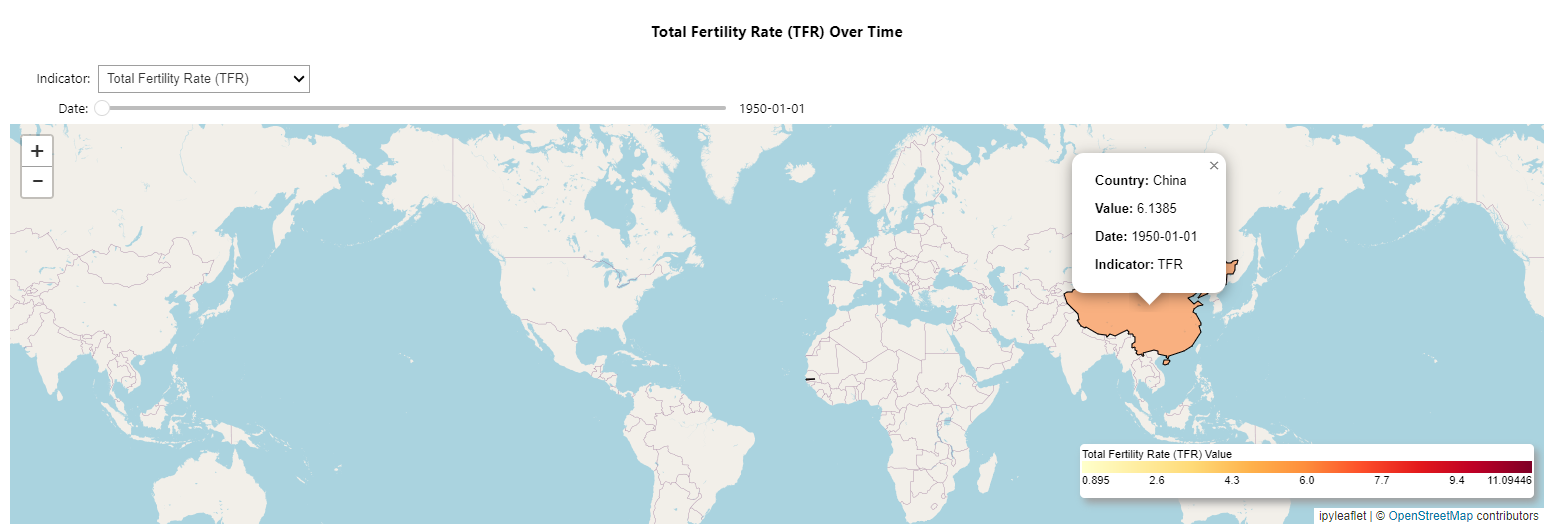

In [3]:
from IPython.display import Image

#Display Images of the data
Image(filename='data/Images/TFR_1950_01_01.png', width=800, height=800)

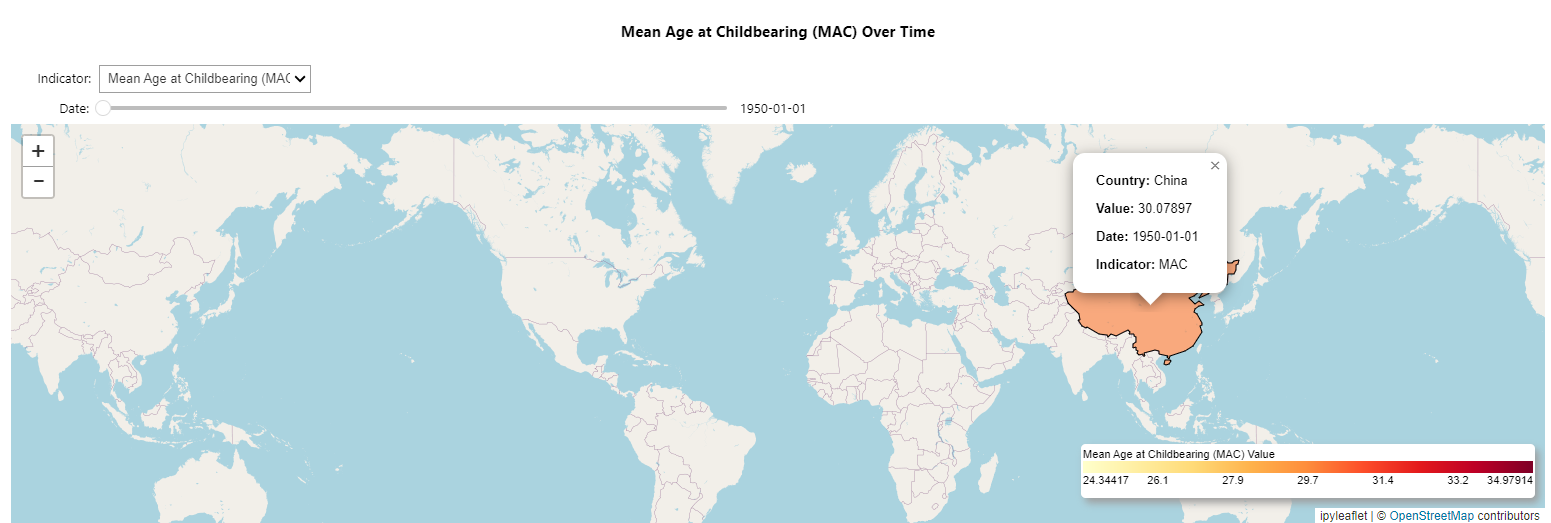

In [4]:
Image(filename='data/Images/MAC_1950_01_01.png', width=800, height=800)


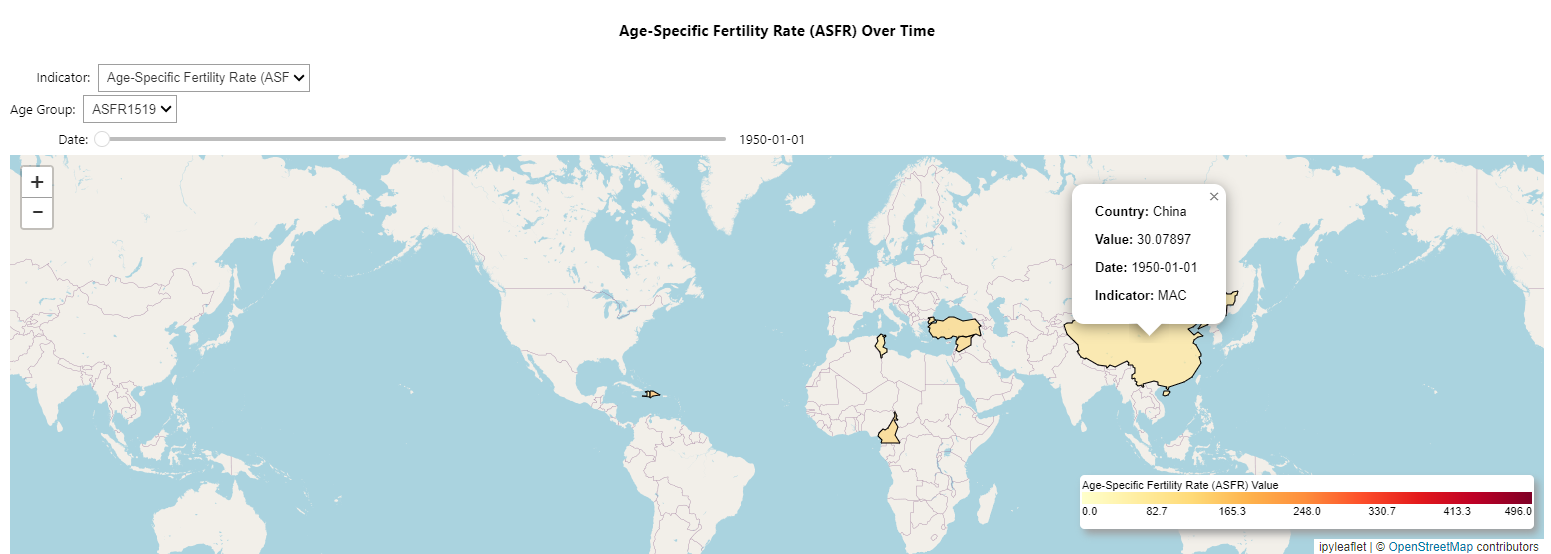

In [5]:
Image(filename='data/Images/ASFR_1950_01_01.png', width=800, height=800)


## Design Elements and Justification
The main design choice for this project was to use an interactive world map to display fertility data across different countries and time periods. This allows users to engage directly with the data, exploring trends over time and across regions. The map uses a color scale to represent fertility rates, making it easy to compare countries at a glance. 

**Design Justification:**
- **Interactivity**: Enables exploration of specific regions and time periods.
- **Color coding**: Facilitates quick comparison of fertility rates across countries.
- **Temporal slider**: Provides a clear view of how fertility trends evolve over time.



### Read the United Nations data for fertility.

Three tabs are in the data:
- INFORMATION NOTE
  - Loaded as `df_information_note`
- Database Field Descriptions
  - Loaded as `df_feild_description`
- FERTILITY INDICATORS
  - `df_fertility_indicators`


In [6]:
df_information_note = pd.read_excel('data/undesa_pd_2019_world_fertility_dataset.xlsx', sheet_name='INFORMATION NOTE', skiprows=6)
print('Information Notes: ')
print(df_information_note)
df_feild_description = pd.read_excel('data/undesa_pd_2019_world_fertility_dataset.xlsx', sheet_name='Database Field Descriptions')
print('Feild Descriptions: ')
print(df_feild_description)

Information Notes: 
Empty DataFrame
Columns: [Unnamed: 0, World Fertility Data 2019 presents data on age-specific fertility rates, total fertility and mean age at childbearing for 201 countries or areas of the world. The database includes data from civil registration systems, population censuses, and sample surveys available as of August 2019 and covers the time period from 1950 to the present. 

The World Fertility Data database builds on the historical repository of demographic data and census and survey reports collected over the past 50 years by the Population Division and Statistics Division of the Department of Economic and Social Affairs (DESA) of the United Nations Secretariat. Data derived from censuses are generally reported by National Statistical Offices to the Statistics Division. Census data are also obtained from official census publications produced by National Statistical Offices. Estimates based on data compiled from civil registration systems are generally obtained f


Data location for reproducibility:
 
The data can be accessed at the following location: [World Fertility Data 2019](https://www.un.org/development/desa/pd/data/world-fertility-data)
 
Citation: United Nations, Department of Economic and Social Affairs, Population Division (2019). *World Fertility Data 2019*. POP/DB/Fert/Rev2019.




Load the data

Load the data for the fertility indicators



In [7]:
# Skip the first 6 rows as they are not needed for this analysis.
df_fertility_indicators = pd.read_excel('./data/undesa_pd_2019_world_fertility_dataset.xlsx', sheet_name='FERTILITY INDICATORS', skiprows=6)

# Rename the column 'Country or Area' to 'country' and 'Country or Area Code' to 'country_code'
df_fertility_indicators.rename(columns={'Country or Area': 'country', 'Country or Area Code': 'country_code'}, inplace=True)


### Update date field 
The current field is in a numerical format. The following converts it to a Year-month-day format.



In [8]:

# This function returns dates that are in the format of 'YYYY-MM-DD'
def convert_fractional_year(fractional_year):
    # Handle NaN values
    if pd.isnull(fractional_year):
        return None
    # Extract the integer part of the year
    year = int(fractional_year)
    
    # Calculate the fraction of the year
    fraction = fractional_year - year
    
    # Calculate the number of days in the year
    days_in_year = 366 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 365
    
    # Calculate the number of days to add
    days_to_add = int(fraction * days_in_year)
    
    # Get the start date of the year
    start_date = datetime.date(year, 1, 1)
    
    # Calculate the final date
    final_date = start_date + datetime.timedelta(days=days_to_add)
    
    return final_date
# Extract the day and month from the 'Date' column and create new columns 'day' and 'month'

# Convert the fractional year to a date
df_fertility_indicators['Date'] = df_fertility_indicators['Date'].apply(convert_fractional_year)


### World Map
 
This section loads the world map data from [Natural Earth Data](https://www.naturalearthdata.com/downloads/110m-physical-vectors/).


In [9]:

# Load the map data
world_map_data = gpd.read_file('./Data/Map_data/ne_110m_admin_0_countries.shp')

# Ensure that country_code is numeric and matches the codes in df_fertility_indicators
world_map_data['country_code'] = world_map_data['ISO_N3'].astype(int)




### Combining World Data with Fertility Dataset



In [10]:

# Merge the fertility indicators with the world map data
df_world_map = world_map_data.merge(df_fertility_indicators, on='country_code', how='left')


# Convert the 'Date' column to datetime dtype
df_world_map['Date'] = pd.to_datetime(df_world_map['Date'])

# Keep only the columns needed for the graphs
df_world_map = df_world_map[['country', 'geometry', 'Date', 'Indicator', 'Value']]

# Drop rows with missing geometry or value
df_world_map = df_world_map.dropna(subset=['geometry', 'Value'])




### Extracting Indicators and Preparing Data



In [11]:
# Get the unique indicators
df_world_map_indicators = df_world_map['Indicator'].unique()

# Filter indicators that start with 'ASFR'
asfr_indicators = [indicator for indicator in df_world_map_indicators if str(indicator).startswith('ASFR')]
df_asfr_indicators = df_world_map[df_world_map['Indicator'].isin(asfr_indicators)].copy()

# Filter indicators that start with 'TFR'
tfr_indicators = [indicator for indicator in df_world_map_indicators if str(indicator).startswith('TFR')]
df_tfr_indicators = df_world_map[df_world_map['Indicator'].isin(tfr_indicators)].copy()

# Filter indicators that start with 'MAC'
mac_indicators = [indicator for indicator in df_world_map_indicators if str(indicator).startswith('MAC')]
df_mac_indicators = df_world_map[df_world_map['Indicator'].isin(mac_indicators)].copy()




### Preparing Age-Specific Fertility Rate Dataframes



In [12]:
def prepare_asfr_dataframes(asfr_indicators, df_asfr_indicators):
    # Create a dictionary to hold dataframes for each ASFR indicator
    asfr_dfs = {}
    for indicator in asfr_indicators:
        df_indicator = df_asfr_indicators[df_asfr_indicators['Indicator'] == indicator].copy()
        asfr_dfs[indicator] = df_indicator

    # Map age group labels to dataframes
    age_group_dfs = {
        '15-19': asfr_dfs.get('ASFR1519', pd.DataFrame()),
        '20-24': asfr_dfs.get('ASFR2024', pd.DataFrame()),
        '25-29': asfr_dfs.get('ASFR2529', pd.DataFrame()),
        '30-34': asfr_dfs.get('ASFR3034', pd.DataFrame()),
        '35-39': asfr_dfs.get('ASFR3539', pd.DataFrame()),
        '40-44': asfr_dfs.get('ASFR4044', pd.DataFrame()),
        '45-49': asfr_dfs.get('ASFR4549', pd.DataFrame())
    }

    # Ensure that the 'geometry' column is of type shapely geometries
    for df in age_group_dfs.values():
        if not df.empty and df['geometry'].dtype == object:
            df['geometry'] = df['geometry'].apply(lambda x: x if isinstance(x, shapely.geometry.base.BaseGeometry) else shapely.wkt.loads(x))

    return age_group_dfs

# Call the function to prepare the dataframes
age_group_dfs = prepare_asfr_dataframes(asfr_indicators, df_asfr_indicators)


## Interactive Map

In [21]:
# Import necessary libraries
import ipywidgets as widgets
from ipyleaflet import Map, GeoJSON, Popup, WidgetControl
import branca.colormap as cm
from shapely.geometry import shape
from ipywidgets import HTML, VBox
import pandas as pd  # Ensure pandas is imported

# Assuming df_tfr_indicators, df_asfr_indicators, df_mac_indicators are already defined
# and have the necessary columns ('Date', 'Value', 'geometry', 'Indicator', 'country')
# Assuming age_group_dfs is a dictionary mapping age group labels to dataframes

# Global variable to keep track of the current date
current_date = None

# Initialize the selected dataframe and unique dates
df_selected, unique_dates_str = initialize_selected_dataframe(indicator_dropdown.value, age_group_dfs, dataframes)

# Set current_date to the first available date at the start
current_date = unique_dates_str[0]  # Use the earliest date initially

# Create the date slider widget
date_slider = widgets.SelectionSlider(
    options=unique_dates_str,
    description='Year:',
    value=current_date,  # Set initial value to current_date
    orientation='horizontal',
    layout={'width': '800px'}
)

# Function to update the map when the date slider value changes
def on_date_change(change):
    global current_date
    if change['type'] == 'change' and change['name'] == 'value':
        # Update the global current_date to keep track
        current_date = change['new']
        # Update the GeoJSON data for the new date
        new_geojson_data = get_geojson_for_date(current_date, df_selected)
        geo_json.data = new_geojson_data

# Observe changes in the date slider
date_slider.observe(on_date_change, names='value')

# Create a dictionary mapping indicator names to dataframes
dataframes = {
    'Total Fertility Rate (TFR)': df_tfr_indicators,
    'Age-Specific Fertility Rate (ASFR)': df_asfr_indicators,
    'Mean Age at Childbearing (MAC)': df_mac_indicators
}

# Create the indicator dropdown widget
indicator_dropdown = widgets.Dropdown(
    options=list(dataframes.keys()),
    description='Indicator:',
    value='Total Fertility Rate (TFR)'
)

# Create the age group dropdown widget, initially hidden
age_group_dropdown = widgets.Dropdown(
    options=list(age_group_dfs.keys()),
    description='Age Group:',
    value=list(age_group_dfs.keys())[0],
    layout=widgets.Layout(display='none')  # Initially hidden
)

# Initialize the selected dataframe
if indicator_dropdown.value == 'Age-Specific Fertility Rate (ASFR)':
    # Show age group dropdown
    age_group_dropdown.layout.display = 'block'
    df_selected = age_group_dfs[age_group_dropdown.value]
else:
    # Hide age group dropdown
    age_group_dropdown.layout.display = 'none'
    df_selected = dataframes[indicator_dropdown.value]

def initialize_selected_dataframe(indicator_value, age_group_dfs, dataframes):
    if indicator_value == 'Age-Specific Fertility Rate (ASFR)':
        # Show age group dropdown
        age_group_dropdown.layout.display = 'block'
        df_selected = age_group_dfs[age_group_dropdown.value]
    else:
        # Hide age group dropdown
        age_group_dropdown.layout.display = 'none'
        df_selected = dataframes[indicator_value]

    # Ensure the 'Date' column is in datetime format
    df_selected['Date'] = pd.to_datetime(df_selected['Date'])

    # Get the list of unique dates and convert them to strings for the slider
    unique_dates = sorted(df_selected['Date'].dropna().unique())
    unique_dates_str = [date.strftime('%Y') for date in unique_dates]

    return df_selected, unique_dates_str

# Initialize the selected dataframe and unique dates
df_selected, unique_dates_str = initialize_selected_dataframe(indicator_dropdown.value, age_group_dfs, dataframes)

# Create the date slider widget
date_slider = widgets.SelectionSlider(
    options=unique_dates_str,
    description='Year:',
    orientation='horizontal',
    layout={'width': '800px'}
)

# Create the map centered on the world with an appropriate zoom level
m = Map(center=(20, 0), zoom=2)

# Get min and max values for the data to set up the color scale
vmin = df_selected['Value'].min()
vmax = df_selected['Value'].max()

# Create a color map using branca.colormap
cmap = cm.linear.YlOrRd_09.scale(vmin, vmax)
cmap.caption = 'Total Fertility Rate (TFR) Value'

# Convert the LinearColormap to a DOMWidget and add it to the map
colormap_html = HTML(value=cmap._repr_html_())
colormap_control = WidgetControl(widget=colormap_html, position='bottomright')
m.add_control(colormap_control)

# Define the style function to style each feature based on its 'Value'
def style_function(feature):
    value = feature['properties']['Value']
    if value is not None:
        color = cmap(value)
    else:
        color = '#8c8c8c'  # Gray color for missing data
    return {
        'fillColor': color,
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6
    }

# Function to get GeoJSON data for a selected date and dataframe
def get_geojson_for_date(year, df):
    # Convert date string back to datetime
    date = pd.to_datetime(year)
    # Filter the data for the selected date
    df_date = df[df['Date'].dt.strftime('%Y') == year].copy()
    # Convert 'Date' column to string to avoid JSON serialization issues
    df_date['Date'] = df_date['Date'].dt.strftime('%Y')
    # Convert the GeoDataFrame to GeoJSON format
    geojson_data = df_date.__geo_interface__
    return geojson_data

# Function to handle click events on the map features
def on_click(**kwargs):
    # Extract the feature from kwargs
    feature = kwargs.get('feature')
    if feature is None:
        print("Feature not found in kwargs")
        return  # Can't proceed without feature

    # Get geometry from the feature
    geometry = feature.get('geometry')
    if geometry is None:
        print("Geometry not found in feature")
        return  # Can't proceed without geometry

    # Convert geometry to Shapely object
    shapely_geom = shape(geometry)
    centroid = shapely_geom.centroid
    coordinates = [centroid.y, centroid.x]  # Note: latitude, longitude

    # Extract properties
    properties = feature.get('properties', {})

    country = properties.get('country', 'Unknown')
    value = properties.get('Value', 'No data')
    year = properties.get('Date', 'No date')
    indicator = properties.get('Indicator', 'Unknown')

    # Create the popup content
    popup_content = f"""
    <b>Country:</b> {country}<br>
    <b>Value:</b> {value}<br>
    <b>Date:</b> {year}<br>
    <b>Indicator:</b> {indicator}
    """

    # Create and display the popup
    popup = Popup(
        location=coordinates,
        child=widgets.HTML(value=popup_content),
        close_button=True,
        auto_close=True,
        close_on_escape_key=True
    )
    m.add_layer(popup)

# Define the initial GeoJSON data
initial_date = unique_dates_str[0]  # Use the earliest date in the dataset
geojson_data = get_geojson_for_date(initial_date, df_selected)

# Create the GeoJSON layer with the style function
geo_json = GeoJSON(
    data=geojson_data,
    style={},  # Provide a default style or an empty dict
    style_callback=style_function,
    hover_style={'fillColor': 'white', 'fillOpacity': 0.2},
    name='Fertility Data'
)

# Attach the click event handler
geo_json.on_click(on_click)

# Add the GeoJSON layer to the map
m.add_layer(geo_json)

# Function to update the map when the date slider value changes
def on_date_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        new_date = change['new']
        # Update the GeoJSON data for the new date
        new_geojson_data = get_geojson_for_date(new_date, df_selected)
        geo_json.data = new_geojson_data

# Observe changes in the date slider
date_slider.observe(on_date_change, names='value')

# Function to update the map when the indicator selection changes
def update_indicator(change):
    global df_selected, cmap, current_date
    selected_indicator = change['new']
    
    if selected_indicator == 'Age-Specific Fertility Rate (ASFR)':
        # Show the age group dropdown
        age_group_dropdown.layout.display = 'block'
        # Get the selected age group
        selected_age_group = age_group_dropdown.value
        df_selected = age_group_dfs[selected_age_group]
    else:
        # Hide the age group dropdown
        age_group_dropdown.layout.display = 'none'
        df_selected = dataframes[selected_indicator]
    
    # Ensure the 'Date' column is in datetime format
    df_selected['Date'] = pd.to_datetime(df_selected['Date'])
    
    # Get the list of unique dates and convert them to strings for the slider
    unique_dates = sorted(df_selected['Date'].dropna().unique())
    unique_dates_str = [date.strftime('%Y') for date in unique_dates]
    
    # Update the date slider options but keep the current_date selected if possible
    date_slider.options = unique_dates_str
    
    # If the current date is available in the new indicator, keep it selected
    if current_date in unique_dates_str:
        date_slider.value = current_date
    else:
        # If the current date isn't available, select the closest available date
        current_date = unique_dates_str[0]
        date_slider.value = current_date
    
    # Update the color map based on the value range of the selected dataframe
    vmin = df_selected['Value'].min()
    vmax = df_selected['Value'].max()
    cmap = cm.linear.YlOrRd_09.scale(vmin, vmax)
    cmap.caption = f'{selected_indicator} Value'
    
    # Update the color map control on the map
    colormap_html.value = cmap._repr_html_()
    
    # Update the style function to use the new color map
    geo_json.style_callback = style_function
    
    # Update the GeoJSON data for the current date
    geojson_data = get_geojson_for_date(current_date, df_selected)
    geo_json.data = geojson_data
    
    # Update the title
    title_widget.value = f"<h3 style='text-align:center;'>{selected_indicator} Over Time</h3>"

# Observe changes in the indicator dropdown
indicator_dropdown.observe(update_indicator, names='value')

# Observe changes in the indicator dropdown
indicator_value = indicator_dropdown.observe(update_indicator, names='value')

# Function to update the map when the age group selection changes
def update_age_group(change, indicator_value=indicator_dropdown):
    global df_selected, cmap
    selected_age_group = change['new']
    df_selected = age_group_dfs[selected_age_group]
    
    # Ensure the 'Date' column is in datetime format
    df_selected['Date'] = pd.to_datetime(df_selected['Date'])
    
    # Get the list of unique dates and convert them to strings for the slider
    unique_dates = sorted(df_selected['Date'].dropna().unique())
    unique_dates_str = [date.strftime('%Y') for date in unique_dates]
    
    # Update the date slider options
    date_slider.options = unique_dates_str
    # Set the date slider value to the first date
    date_slider.value = unique_dates_str[0]
    
    # Update the color map based on the value range of the selected dataframe
    vmin = df_selected['Value'].min()
    vmax = df_selected['Value'].max()
    cmap = cm.linear.YlOrRd_09.scale(vmin, vmax)
    cmap.caption = f'{indicator_dropdown.value} Value'
    
    # Update the color map control on the map
    colormap_html.value = cmap._repr_html_()
    
    # Update the style function to use the new color map
    geo_json.style_callback = style_function
    
    # Update the GeoJSON data for the initial date
    # initial_date = date_slider.value
    geojson_data = get_geojson_for_date(current_date, df_selected)
    geo_json.data = geojson_data

# Observe changes in the age group dropdown
age_group_dropdown.observe(update_age_group, names='value')

# Create the title widget
title_widget = HTML(
    value=f"<h3 style='text-align:center;'>{indicator_dropdown.value} Over Time</h3>"
)

# Arrange the widgets in a VBox
vbox_children = [title_widget, indicator_dropdown, age_group_dropdown, date_slider, m]
vbox = VBox(vbox_children)

# Adjust visibility of age group dropdown based on the initial indicator selection
if indicator_dropdown.value != 'Age-Specific Fertility Rate (ASFR)':
    age_group_dropdown.layout.display = 'none'
else:
    age_group_dropdown.layout.display = 'block'

# Display the layout
display(vbox)

## Recap of Data, Goals, and Tasks

The main goal of this project is to visualize global fertility trends using the World Fertility Data 2019. This data includes age-specific fertility rates, total fertility, and mean age at childbearing for over 200 countries. The aim of the visualizations is to present this data in an engaging and interactive way, allowing users to explore how fertility patterns have changed across different regions and age groups.

## Key tasks involved:
- Reading and cleaning the fertility dataset.
- Mapping fertility rates globally using interactive maps.
- Providing insight into global demographic trends and projecting potential future changes.

## Evaluation and Feedback
###  Evaluation Process
 - Participants: One English tutor and two mathematics professors.
 - Procedure: Participants interacted with the map, exploring different regions, indicators, and time periods. They were asked to provide feedback on usability, clarity, and overall effectiveness.
### Synthesis of Findings
What Worked Well:
-	Ease of Navigation: The map's interactivity made it intuitive to explore the data.
-	Visual Appeal: Color-coding effectively highlighted differences between regions.
-	Engagement: Users found the map engaging and informative.
Areas for Improvement:
1.	Date Slider Granularity: The slider cycled through days, which was too granular for annual data.
    - Solution: Adjust the slider to increment by years instead of days.
2.	Consistency Between Datasets: The selected date did not remain consistent when switching indicators.
    - Solution: Implement code to retain the selected date across different datasets, defaulting to the closest available date if necessary.
3.	Color Mapping Clarity: The color scale was challenging to interpret due to a concentration of data in lighter shades.
    - Solution: Adjust the color palette or use data normalization techniques to enhance visual differentiation.
________________________________________
### Conclusion
This project successfully visualized global fertility trends using an interactive map, providing valuable insights into how fertility patterns have evolved over time and across regions. Visualization aids in understanding complex demographic data, making it accessible to a broader audience.
Future Improvements:
- Enhanced Legends and Tooltips: Provide clearer legends and more detailed tooltips with additional country-specific information.
- Performance Optimization: Optimize data loading and processing for smoother user experience.
- Extended Data Integration: Incorporate additional demographic indicators for a more comprehensive analysis.
________________________________________
References
- United Nations, Department of Economic and Social Affairs, Population Division (2019). World Fertility Data 2019. POP/DB/Fert/Rev2019.
- Natural Earth Data. 1:110m Cultural Vectors. Retrieved from Natural Earth Data Downloads.
- The final project is published on [GitHub.](https://github.com/DJ-Greenwood/Data_visualization.git)
